# Simple question answering with memory

This demo implements a simple form of question answering. Two features (color and shape)
will be bound by circular convolution and stored in a memory population. A cue will be
used to determine either one of the features by deconvolution.

When you run the network, it will start by binding `RED` and `CIRCLE` for 0.25 seconds
and then binding `BLUE` and `SQUARE` for 0.25 seconds. Both bound semantic pointers are
stored in a memory population. Then the network is asked with the cue. For example, when
the cue is `CIRCLE` the network will respond with `RED`.

In [1]:
%matplotlib inline

import nengo
import matplotlib.pyplot as plt

import nengo_spa as spa

seed = 0

## Define the input functions

The color input will `RED` and then `BLUE` for 0.25 seconds each before being turned
off. In the same way the shape input will be `CIRCLE` and then `SQUARE` for 0.25 seconds
each. Thus, the network will bind alternatingly `RED * CIRCLE` and `BLUE * SQUARE` for
0.5 seconds each.

The cue for deconvolving bound semantic pointers will be turned off for 0.5 seconds and
then cycles through `CIRCLE`, `RED`, `SQUARE`, and `BLUE` within one second.

In [2]:
def color_input(t):
    if t < 0.25:
        return "RED"
    elif t < 0.5:
        return "BLUE"
    else:
        return "0"


def shape_input(t):
    if t < 0.25:
        return "CIRCLE"
    elif t < 0.5:
        return "SQUARE"
    else:
        return "0"


def cue_input(t):
    if t < 0.5:
        return "0"
    sequence = ["0", "CIRCLE", "RED", "0", "SQUARE", "BLUE"]
    idx = int(((t - 0.5) // (1.0 / len(sequence))) % len(sequence))
    return sequence[idx]

## Create the model

In [3]:
# Number of dimensions for the Semantic Pointers
dimensions = 32

model = spa.Network(label="Simple question answering", seed=seed)

with model:
    color_in = spa.Transcode(color_input, output_vocab=dimensions)
    shape_in = spa.Transcode(shape_input, output_vocab=dimensions)
    conv = spa.State(dimensions, subdimensions=4, feedback=1.0, feedback_synapse=0.4)
    cue = spa.Transcode(cue_input, output_vocab=dimensions)
    out = spa.State(dimensions)

    # Connect the buffers
    color_in * shape_in >> conv
    conv * ~cue >> out

## Probe the output

In [4]:
with model:
    model.config[nengo.Probe].synapse = nengo.Lowpass(0.03)
    p_color_in = nengo.Probe(color_in.output)
    p_shape_in = nengo.Probe(shape_in.output)
    p_cue = nengo.Probe(cue.output)
    p_conv = nengo.Probe(conv.output)
    p_out = nengo.Probe(out.output)

## Run the model

In [5]:
with nengo.Simulator(model) as sim:
    sim.run(3.0)

## Plot the results

Text(0.5, 0, 'time [s]')

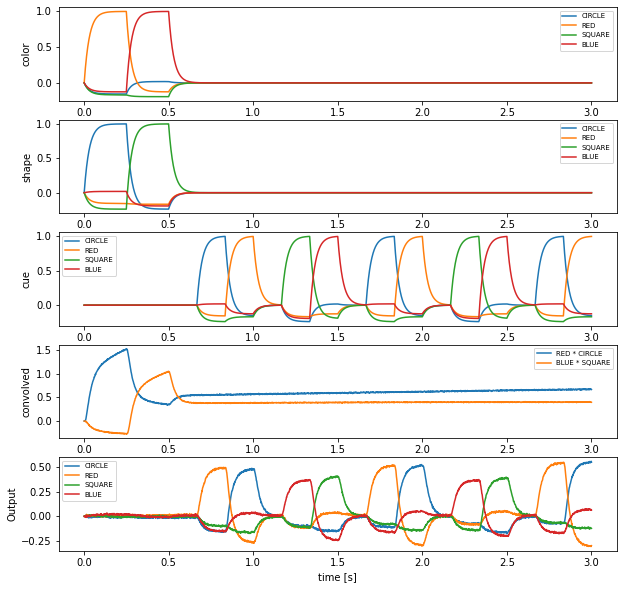

In [6]:
plt.figure(figsize=(10, 10))
vocab = model.vocabs[dimensions]

plt.subplot(5, 1, 1)
plt.plot(sim.trange(), spa.similarity(sim.data[p_color_in], vocab))
plt.legend(vocab.keys(), fontsize="x-small")
plt.ylabel("color")

plt.subplot(5, 1, 2)
plt.plot(sim.trange(), spa.similarity(sim.data[p_shape_in], vocab))
plt.legend(vocab.keys(), fontsize="x-small")
plt.ylabel("shape")

plt.subplot(5, 1, 3)
plt.plot(sim.trange(), spa.similarity(sim.data[p_cue], vocab))
plt.legend(vocab.keys(), fontsize="x-small")
plt.ylabel("cue")

plt.subplot(5, 1, 4)
for pointer in ["RED * CIRCLE", "BLUE * SQUARE"]:
    plt.plot(sim.trange(), vocab.parse(pointer).dot(sim.data[p_conv].T), label=pointer)
plt.legend(fontsize="x-small")
plt.ylabel("convolved")

plt.subplot(5, 1, 5)
plt.plot(sim.trange(), spa.similarity(sim.data[p_out], vocab))
plt.legend(vocab.keys(), fontsize="x-small")
plt.ylabel("Output")
plt.xlabel("time [s]")

The plots of `shape`, `color`, and `convolved` show that first `RED * CIRCLE` and then
`BLUE * SQUARE` will be loaded into the `convolved` buffer so after 0.5 seconds it
represents the superposition `RED * CIRCLE + BLUE * SQUARE`.

The last plot shows that the output is most similar to the semantic pointer bound to the
current cue. For example, when `RED` and `CIRCLE` are being convolved and the cue is
`CIRCLE`, the output is most similar to `RED`. Thus, it is possible to unbind semantic
pointers from the superposition stored in `convolved`.